### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd 

import matplotlib as mpl 
import matplotlib.cm as cm 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import stop_words
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer 

import string
import re

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import metrics

from time import time

import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.feature_extraction.stop_words module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_extraction.text. Anything that cannot be imported from sklearn.feature_extraction.text is now part of the private API.
  warnings.warn(message, FutureWarning)


## Analysis of Data

In [2]:
data = pd.read_csv('/kaggle/input/newdata/DATASET2.csv')
display(data.shape) 

(255, 3)

In [ ]:
data.head()

In [4]:
data["label"].value_counts()

Approved    198
Pending      44
Reject       13
Name: label, dtype: int64

In [5]:
data.replace('Pending','Reject', inplace = True)
data["label"].value_counts()

Approved    198
Reject       57
Name: label, dtype: int64

In [6]:
data.replace('Approved',0, inplace = True)
data.replace('Reject',1, inplace = True)
data.label

0      1
1      0
2      0
3      0
4      0
      ..
250    1
251    1
252    1
253    1
254    1
Name: label, Length: 255, dtype: int64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    255 non-null    object
 1   label   255 non-null    int64 
 2   text    255 non-null    object
dtypes: int64(1), object(2)
memory usage: 6.1+ KB


## Text Pre-processing

In [8]:
# data['relevance'] = data.relevance.map({'yes':1, 'no':0}) # relevant is 1, not-relevant is 0 
temp = data[["text","label"]] # taking text input and output variable as relevance
temp = temp[:1000]
temp.shape

(255, 2)

In [ ]:
data = temp
data

### Text Cleaning

In [10]:
import spacy
nlp = spacy.load('en_core_web_sm')

stopwords = stop_words.ENGLISH_STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean(doc):
    text_no_namedentities = []
    document = nlp(doc)
    ents = [e.text for e in document.ents]
    for item in document:
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)
    doc = (" ".join(text_no_namedentities))

    doc = doc.lower().strip()
    doc = doc.replace("</br>", " ") 
    doc = doc.replace("-", " ") 
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    doc = " ".join([token for token in doc.split() if token not in stopwords])    
    doc = "".join([lemmatizer.lemmatize(word) for word in doc])
    return doc

In [ ]:
data['text'] = data['text'].apply(clean)
data.head()

## TF-IDF

In [12]:
docs = list(data['text'])
tfidf_vectorizer = TfidfVectorizer(use_idf=True, max_features = 20000) 
tfidf_vectorizer_vectors = tfidf_vectorizer.fit_transform(docs)
docs = tfidf_vectorizer_vectors.toarray()

In [13]:
X = docs 
y = data['label']
print(X.shape, y.shape)

(255, 4605) (255,)


In [14]:
fig = go.Figure([go.Bar(x=y.value_counts().index, y=y.value_counts().tolist())])
fig.update_layout(
    title="Values in each label",
    xaxis_title="label",
    yaxis_title="Values")
fig.show()

### Train-Test Split

In [15]:
SEED=123
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(204, 4605) (204,)
(51, 4605) (51,)


In [16]:
y.value_counts()

0    198
1     57
Name: label, dtype: int64

In [17]:
y_train.value_counts()

0    158
1     46
Name: label, dtype: int64

## no sampling

**Gaussian Naive Bayes**

CPU times: user 15.3 ms, sys: 8.94 ms, total: 24.2 ms
Wall time: 22.9 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7843137254901961
              precision    recall  f1-score   support

    Approved       0.78      1.00      0.88        40
      Reject       0.00      0.00      0.00        11

    accuracy                           0.78        51
   macro avg       0.39      0.50      0.44        51
weighted avg       0.62      0.78      0.69        51



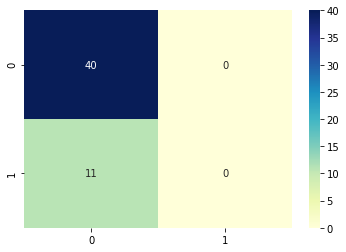

In [18]:
gnb = GaussianNB() 
%time gnb.fit(X_train, y_train)

y_pred_train = gnb.predict(X_train)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 8.24 ms, sys: 1.02 ms, total: 9.26 ms
Wall time: 5.9 ms

Training Accuracy score: 0.7745098039215687
Testing Accuracy score: 0.7843137254901961
              precision    recall  f1-score   support

    Approved       0.78      1.00      0.88        40
      Reject       0.00      0.00      0.00        11

    accuracy                           0.78        51
   macro avg       0.39      0.50      0.44        51
weighted avg       0.62      0.78      0.69        51



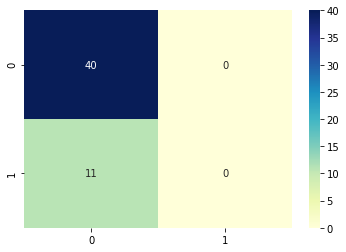

In [19]:
mnb = MultinomialNB() 
%time mnb.fit(X_train, y_train)

y_pred_train = mnb.predict(X_train)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 48 ms, sys: 2.94 ms, total: 50.9 ms
Wall time: 31.5 ms

Training Accuracy score: 0.7745098039215687
Testing Accuracy score: 0.7843137254901961
              precision    recall  f1-score   support

    Approved       0.78      1.00      0.88        40
      Reject       0.00      0.00      0.00        11

    accuracy                           0.78        51
   macro avg       0.39      0.50      0.44        51
weighted avg       0.62      0.78      0.69        51



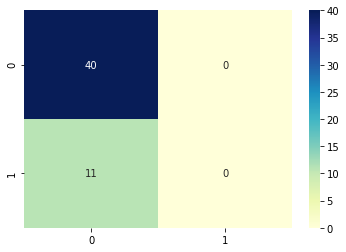

In [20]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train, y_train)

y_pred_train = lr.predict(X_train)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 12.6 ms, sys: 2.89 ms, total: 15.5 ms
Wall time: 13.1 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7647058823529411
              precision    recall  f1-score   support

    Approved       0.79      0.95      0.86        40
      Reject       0.33      0.09      0.14        11

    accuracy                           0.76        51
   macro avg       0.56      0.52      0.50        51
weighted avg       0.69      0.76      0.71        51



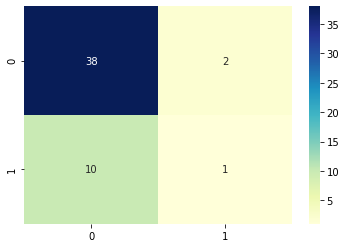

In [21]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train, y_train)

y_pred_train = svc.predict(X_train)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 84.7 ms, sys: 3.05 ms, total: 87.7 ms
Wall time: 88.5 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7647058823529411
              precision    recall  f1-score   support

    Approved       0.82      0.90      0.86        40
      Reject       0.43      0.27      0.33        11

    accuracy                           0.76        51
   macro avg       0.62      0.59      0.60        51
weighted avg       0.73      0.76      0.74        51



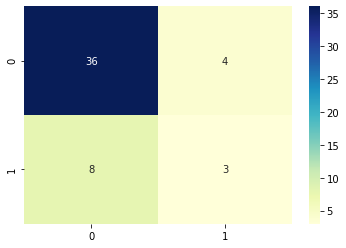

In [22]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train, y_train)

y_pred_train = dt.predict(X_train)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

## upsampling

In [23]:
from imblearn.over_sampling import SMOTE
smt = SMOTE()
X_train_sm, y_train_sm = smt.fit_resample(X_train,y_train)
print(len(X_train_sm))
y_train_sm.value_counts()

316


1    158
0    158
Name: label, dtype: int64

**Gaussian Naive Bayes**

CPU times: user 21 ms, sys: 1 ms, total: 22.1 ms
Wall time: 20.4 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7843137254901961
              precision    recall  f1-score   support

    Approved       0.78      1.00      0.88        40
      Reject       0.00      0.00      0.00        11

    accuracy                           0.78        51
   macro avg       0.39      0.50      0.44        51
weighted avg       0.62      0.78      0.69        51



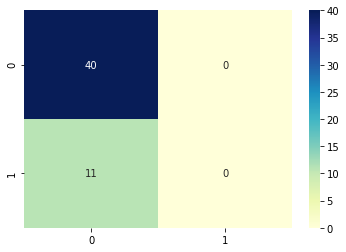

In [24]:
gnb = GaussianNB() 
%time gnb.fit(X_train_sm, y_train_sm)

y_pred_train = gnb.predict(X_train_sm)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 7.42 ms, sys: 1.11 ms, total: 8.53 ms
Wall time: 5.63 ms

Training Accuracy score: 0.9651898734177216
Testing Accuracy score: 0.6274509803921569
              precision    recall  f1-score   support

    Approved       0.84      0.65      0.73        40
      Reject       0.30      0.55      0.39        11

    accuracy                           0.63        51
   macro avg       0.57      0.60      0.56        51
weighted avg       0.72      0.63      0.66        51



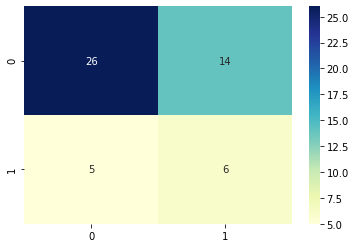

In [25]:
mnb = MultinomialNB() 
%time mnb.fit(X_train_sm, y_train_sm)

y_pred_train = mnb.predict(X_train_sm)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 64.6 ms, sys: 6.75 ms, total: 71.3 ms
Wall time: 38.5 ms

Training Accuracy score: 0.9936708860759493
Testing Accuracy score: 0.7450980392156863
              precision    recall  f1-score   support

    Approved       0.79      0.93      0.85        40
      Reject       0.25      0.09      0.13        11

    accuracy                           0.75        51
   macro avg       0.52      0.51      0.49        51
weighted avg       0.67      0.75      0.70        51



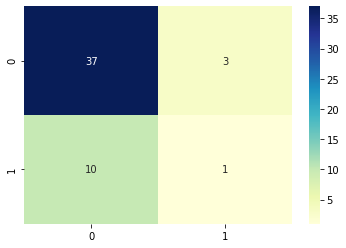

In [26]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train_sm, y_train_sm)

y_pred_train = lr.predict(X_train_sm)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 32.1 ms, sys: 3.01 ms, total: 35.1 ms
Wall time: 17.2 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7647058823529411
              precision    recall  f1-score   support

    Approved       0.79      0.95      0.86        40
      Reject       0.33      0.09      0.14        11

    accuracy                           0.76        51
   macro avg       0.56      0.52      0.50        51
weighted avg       0.69      0.76      0.71        51



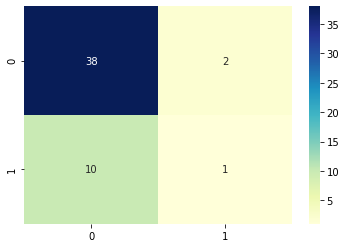

In [27]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train_sm, y_train_sm)

y_pred_train = svc.predict(X_train_sm)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 107 ms, sys: 4.93 ms, total: 112 ms
Wall time: 95.5 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.6470588235294118
              precision    recall  f1-score   support

    Approved       0.78      0.78      0.78        40
      Reject       0.18      0.18      0.18        11

    accuracy                           0.65        51
   macro avg       0.48      0.48      0.48        51
weighted avg       0.65      0.65      0.65        51



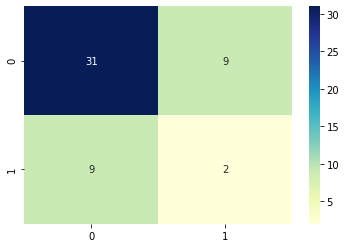

In [28]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_sm, y_train_sm)

y_pred_train = dt.predict(X_train_sm)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_sm, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

## downsampling

In [29]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
print('Original dataset shape %s' % Counter(y_train))
rus = RandomUnderSampler(random_state=42)
X_train_ds, y_train_ds = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_train_ds))

Original dataset shape Counter({0: 158, 1: 46})
Resampled dataset shape Counter({0: 46, 1: 46})


**Gaussian Naive Bayes**

CPU times: user 4.53 ms, sys: 2.89 ms, total: 7.42 ms
Wall time: 6.7 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7254901960784313
              precision    recall  f1-score   support

    Approved       0.80      0.88      0.83        40
      Reject       0.29      0.18      0.22        11

    accuracy                           0.73        51
   macro avg       0.54      0.53      0.53        51
weighted avg       0.69      0.73      0.70        51



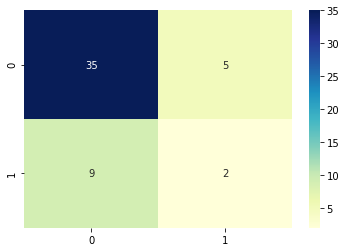

In [30]:
gnb = GaussianNB() 
%time gnb.fit(X_train_ds, y_train_ds)

y_pred_train = gnb.predict(X_train_ds)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 5.49 ms, sys: 113 µs, total: 5.61 ms
Wall time: 3.44 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.5882352941176471
              precision    recall  f1-score   support

    Approved       0.88      0.55      0.68        40
      Reject       0.31      0.73      0.43        11

    accuracy                           0.59        51
   macro avg       0.59      0.64      0.55        51
weighted avg       0.76      0.59      0.62        51



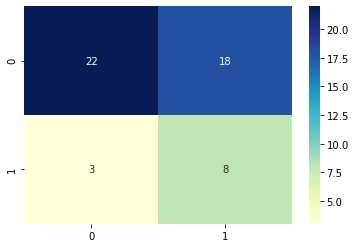

In [31]:
mnb = MultinomialNB() 
%time mnb.fit(X_train_ds, y_train_ds)

y_pred_train = mnb.predict(X_train_ds)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 26.2 ms, sys: 1.02 ms, total: 27.2 ms
Wall time: 15.6 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.6078431372549019
              precision    recall  f1-score   support

    Approved       0.86      0.60      0.71        40
      Reject       0.30      0.64      0.41        11

    accuracy                           0.61        51
   macro avg       0.58      0.62      0.56        51
weighted avg       0.74      0.61      0.64        51



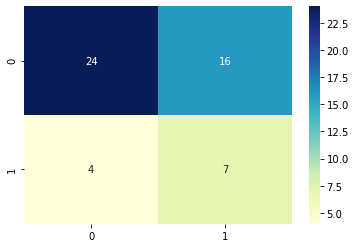

In [32]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train_ds, y_train_ds)

y_pred_train = lr.predict(X_train_ds)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 9.77 ms, sys: 983 µs, total: 10.8 ms
Wall time: 5.69 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.5490196078431373
              precision    recall  f1-score   support

    Approved       0.81      0.55      0.66        40
      Reject       0.25      0.55      0.34        11

    accuracy                           0.55        51
   macro avg       0.53      0.55      0.50        51
weighted avg       0.69      0.55      0.59        51



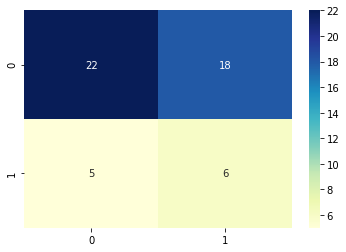

In [33]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train_ds, y_train_ds)

y_pred_train = svc.predict(X_train_ds)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 24.8 ms, sys: 0 ns, total: 24.8 ms
Wall time: 14.8 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.5686274509803921
              precision    recall  f1-score   support

    Approved       0.78      0.62      0.69        40
      Reject       0.21      0.36      0.27        11

    accuracy                           0.57        51
   macro avg       0.50      0.49      0.48        51
weighted avg       0.66      0.57      0.60        51



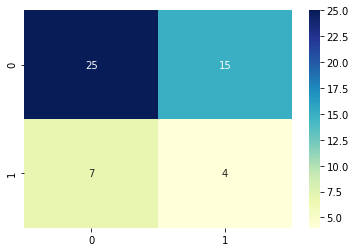

In [34]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_ds, y_train_ds)

y_pred_train = dt.predict(X_train_ds)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ds, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

## middle value of 100

In [35]:
from imblearn.over_sampling import SMOTE

X_new = X_train
y_new = y_train
oversampler = SMOTE(sampling_strategy={1: 100})
X_resampled, y_resampled = oversampler.fit_resample(X_new, y_new)
print('Original dataset shape %s' % Counter(y_resampled))
rus = RandomUnderSampler(random_state=42)
X_train_ud, y_train_ud = rus.fit_resample(X_resampled, y_resampled)
print('Resampled dataset shape %s' % Counter(y_train_ud))

y_train_ud.value_counts()


Original dataset shape Counter({0: 158, 1: 100})
Resampled dataset shape Counter({0: 100, 1: 100})


1    100
0    100
Name: label, dtype: int64

**Gaussian Naive Bayes**

CPU times: user 13.5 ms, sys: 4.9 ms, total: 18.4 ms
Wall time: 17.2 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7647058823529411
              precision    recall  f1-score   support

    Approved       0.78      0.97      0.87        40
      Reject       0.00      0.00      0.00        11

    accuracy                           0.76        51
   macro avg       0.39      0.49      0.43        51
weighted avg       0.61      0.76      0.68        51



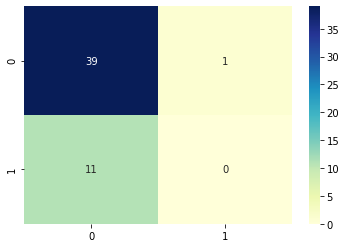

In [36]:
gnb = GaussianNB() 
%time gnb.fit(X_train_ud, y_train_ud)

y_pred_train = gnb.predict(X_train_ud)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 7.05 ms, sys: 1 ms, total: 8.06 ms
Wall time: 4.96 ms

Training Accuracy score: 0.99
Testing Accuracy score: 0.6470588235294118
              precision    recall  f1-score   support

    Approved       0.82      0.70      0.76        40
      Reject       0.29      0.45      0.36        11

    accuracy                           0.65        51
   macro avg       0.56      0.58      0.56        51
weighted avg       0.71      0.65      0.67        51



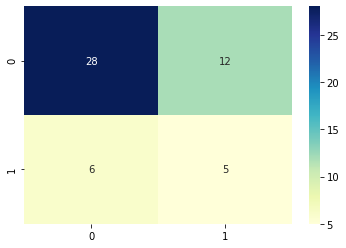

In [37]:
mnb = MultinomialNB() 
%time mnb.fit(X_train_ud, y_train_ud)

y_pred_train = mnb.predict(X_train_ud)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 46.6 ms, sys: 1.98 ms, total: 48.5 ms
Wall time: 23.7 ms

Training Accuracy score: 0.995
Testing Accuracy score: 0.7058823529411765
              precision    recall  f1-score   support

    Approved       0.79      0.85      0.82        40
      Reject       0.25      0.18      0.21        11

    accuracy                           0.71        51
   macro avg       0.52      0.52      0.51        51
weighted avg       0.67      0.71      0.69        51



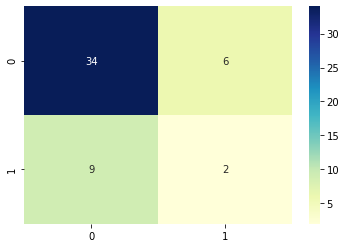

In [38]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train_ud, y_train_ud)

y_pred_train = lr.predict(X_train_ud)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 27.4 ms, sys: 825 µs, total: 28.2 ms
Wall time: 13.2 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7450980392156863
              precision    recall  f1-score   support

    Approved       0.80      0.90      0.85        40
      Reject       0.33      0.18      0.24        11

    accuracy                           0.75        51
   macro avg       0.57      0.54      0.54        51
weighted avg       0.70      0.75      0.72        51



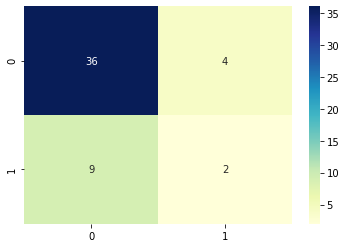

In [39]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train_ud, y_train_ud)

y_pred_train = svc.predict(X_train_ud)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 50.2 ms, sys: 1.95 ms, total: 52.2 ms
Wall time: 37 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.5882352941176471
              precision    recall  f1-score   support

    Approved       0.81      0.62      0.70        40
      Reject       0.25      0.45      0.32        11

    accuracy                           0.59        51
   macro avg       0.53      0.54      0.51        51
weighted avg       0.69      0.59      0.62        51



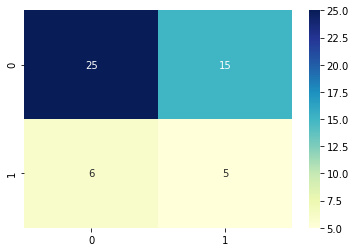

In [40]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_ud, y_train_ud)

y_pred_train = dt.predict(X_train_ud)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

## middle value of 70

In [41]:
from imblearn.over_sampling import SMOTE

X_new = X_train
y_new = y_train
oversampler = SMOTE(sampling_strategy={1: 70})
X_resampled, y_resampled = oversampler.fit_resample(X_new, y_new)
print('Original dataset shape %s' % Counter(y_resampled))
rus = RandomUnderSampler(random_state=42)
X_train_ud, y_train_ud = rus.fit_resample(X_resampled, y_resampled)
print('Resampled dataset shape %s' % Counter(y_train_ud))

y_train_ud.value_counts()


Original dataset shape Counter({0: 158, 1: 70})
Resampled dataset shape Counter({0: 70, 1: 70})


1    70
0    70
Name: label, dtype: int64

**Gaussian Naive Bayes**

CPU times: user 8.94 ms, sys: 1.14 ms, total: 10.1 ms
Wall time: 8.22 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7647058823529411
              precision    recall  f1-score   support

    Approved       0.79      0.95      0.86        40
      Reject       0.33      0.09      0.14        11

    accuracy                           0.76        51
   macro avg       0.56      0.52      0.50        51
weighted avg       0.69      0.76      0.71        51



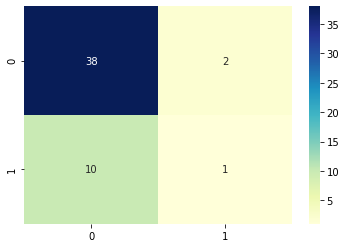

In [42]:
gnb = GaussianNB() 
%time gnb.fit(X_train_ud, y_train_ud)

y_pred_train = gnb.predict(X_train_ud)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 6.45 ms, sys: 31 µs, total: 6.48 ms
Wall time: 4.3 ms

Training Accuracy score: 0.9928571428571429
Testing Accuracy score: 0.6470588235294118
              precision    recall  f1-score   support

    Approved       0.89      0.62      0.74        40
      Reject       0.35      0.73      0.47        11

    accuracy                           0.65        51
   macro avg       0.62      0.68      0.60        51
weighted avg       0.78      0.65      0.68        51



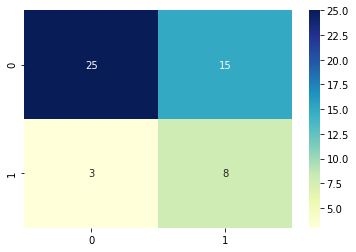

In [43]:
mnb = MultinomialNB() 
%time mnb.fit(X_train_ud, y_train_ud)

y_pred_train = mnb.predict(X_train_ud)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 27.4 ms, sys: 1.17 ms, total: 28.6 ms
Wall time: 16.9 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.6666666666666666
              precision    recall  f1-score   support

    Approved       0.78      0.80      0.79        40
      Reject       0.20      0.18      0.19        11

    accuracy                           0.67        51
   macro avg       0.49      0.49      0.49        51
weighted avg       0.66      0.67      0.66        51



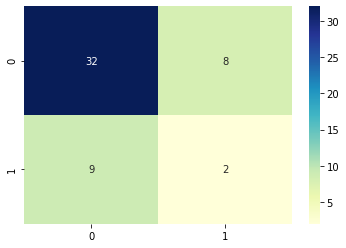

In [44]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train_ud, y_train_ud)

y_pred_train = lr.predict(X_train_ud)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 15.5 ms, sys: 2.9 ms, total: 18.4 ms
Wall time: 8.39 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.6862745098039216
              precision    recall  f1-score   support

    Approved       0.82      0.78      0.79        40
      Reject       0.31      0.36      0.33        11

    accuracy                           0.69        51
   macro avg       0.56      0.57      0.56        51
weighted avg       0.71      0.69      0.70        51



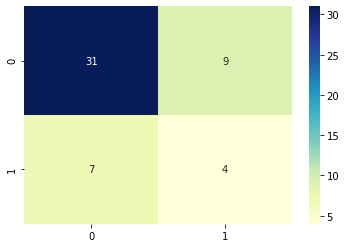

In [45]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train_ud, y_train_ud)

y_pred_train = svc.predict(X_train_ud)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 41 ms, sys: 2.07 ms, total: 43.1 ms
Wall time: 28.6 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.6078431372549019
              precision    recall  f1-score   support

    Approved       0.79      0.68      0.73        40
      Reject       0.24      0.36      0.29        11

    accuracy                           0.61        51
   macro avg       0.51      0.52      0.51        51
weighted avg       0.67      0.61      0.63        51



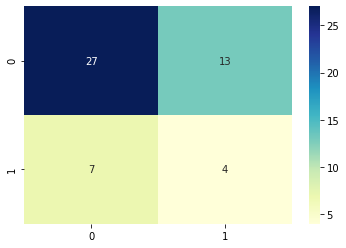

In [46]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_ud, y_train_ud)

y_pred_train = dt.predict(X_train_ud)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

## down to 100 and up to 70

In [47]:
from imblearn.over_sampling import SMOTE

X_new = X_train
y_new = y_train
oversampler = SMOTE(sampling_strategy={1: 70})
X_resampled, y_resampled = oversampler.fit_resample(X_new, y_new)
print('Original dataset shape %s' % Counter(y_resampled))
rus = RandomUnderSampler(random_state=42,sampling_strategy={0:100})
X_train_ud, y_train_ud = rus.fit_resample(X_resampled, y_resampled)
print('Resampled dataset shape %s' % Counter(y_train_ud))

print(y_train_ud.value_counts())


Original dataset shape Counter({0: 158, 1: 70})
Resampled dataset shape Counter({0: 100, 1: 70})
0    100
1     70
Name: label, dtype: int64


**Gaussian Naive Bayes**

CPU times: user 13.7 ms, sys: 1.02 ms, total: 14.7 ms
Wall time: 13.2 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7647058823529411
              precision    recall  f1-score   support

    Approved       0.78      0.97      0.87        40
      Reject       0.00      0.00      0.00        11

    accuracy                           0.76        51
   macro avg       0.39      0.49      0.43        51
weighted avg       0.61      0.76      0.68        51



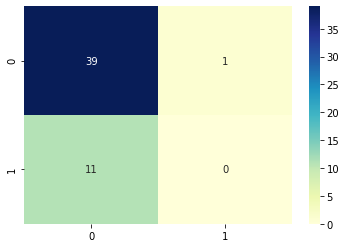

In [48]:
gnb = GaussianNB() 
%time gnb.fit(X_train_ud, y_train_ud)

y_pred_train = gnb.predict(X_train_ud)
y_pred_test = gnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Multinomial Naive Bayes**

CPU times: user 9.26 ms, sys: 20 µs, total: 9.28 ms
Wall time: 5.84 ms

Training Accuracy score: 0.9705882352941176
Testing Accuracy score: 0.803921568627451
              precision    recall  f1-score   support

    Approved       0.80      1.00      0.89        40
      Reject       1.00      0.09      0.17        11

    accuracy                           0.80        51
   macro avg       0.90      0.55      0.53        51
weighted avg       0.84      0.80      0.73        51



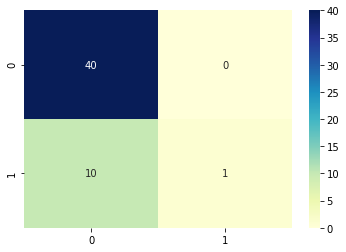

In [49]:
mnb = MultinomialNB() 
%time mnb.fit(X_train_ud, y_train_ud)

y_pred_train = mnb.predict(X_train_ud)
y_pred_test = mnb.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Logistic Regression**

CPU times: user 42.7 ms, sys: 1.98 ms, total: 44.7 ms
Wall time: 24.8 ms

Training Accuracy score: 0.9588235294117647
Testing Accuracy score: 0.803921568627451
              precision    recall  f1-score   support

    Approved       0.80      1.00      0.89        40
      Reject       1.00      0.09      0.17        11

    accuracy                           0.80        51
   macro avg       0.90      0.55      0.53        51
weighted avg       0.84      0.80      0.73        51



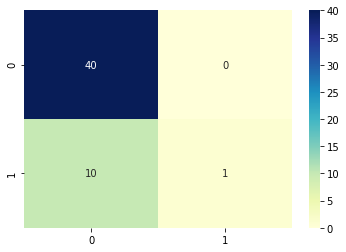

In [50]:
lr = LogisticRegression(random_state=SEED)
%time lr.fit(X_train_ud, y_train_ud)

y_pred_train = lr.predict(X_train_ud)
y_pred_test = lr.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**SVM**

CPU times: user 10.9 ms, sys: 127 µs, total: 11 ms
Wall time: 9.58 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.7254901960784313
              precision    recall  f1-score   support

    Approved       0.80      0.88      0.83        40
      Reject       0.29      0.18      0.22        11

    accuracy                           0.73        51
   macro avg       0.54      0.53      0.53        51
weighted avg       0.69      0.73      0.70        51



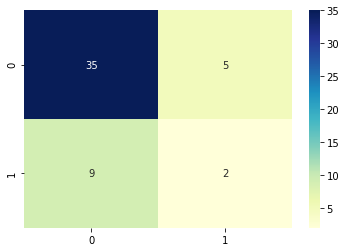

In [51]:
svc =  LinearSVC(class_weight='balanced') 
%time svc.fit(X_train_ud, y_train_ud)

y_pred_train = svc.predict(X_train_ud)
y_pred_test = svc.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

**Decision Tree**

CPU times: user 40.9 ms, sys: 1.07 ms, total: 42 ms
Wall time: 39.6 ms

Training Accuracy score: 1.0
Testing Accuracy score: 0.6666666666666666
              precision    recall  f1-score   support

    Approved       0.81      0.75      0.78        40
      Reject       0.29      0.36      0.32        11

    accuracy                           0.67        51
   macro avg       0.55      0.56      0.55        51
weighted avg       0.70      0.67      0.68        51



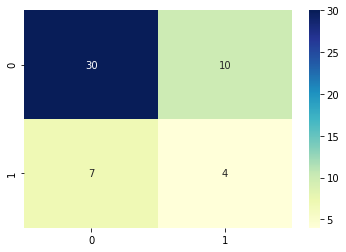

In [52]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=SEED)
%time dt.fit(X_train_ud, y_train_ud)

y_pred_train = dt.predict(X_train_ud)
y_pred_test = dt.predict(X_test)
print("\nTraining Accuracy score:",accuracy_score(y_train_ud, y_pred_train))
print("Testing Accuracy score:",accuracy_score(y_test, y_pred_test))
cm = confusion_matrix(y_test, y_pred_test)
#print('Confusion matrix\n', cm)
print(classification_report(y_test, y_pred_test, target_names=['Approved','Reject']))

cm_matrix = pd.DataFrame(data=cm)
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
plt.show()